## Мерич Дорук Каймакджыоглу
## 1032245391 / НПМмд-01-24

In [1]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
with open('Desktop/scenes/CLEVR_train_scenes.json', 'r') as f:
    train_scenes = json.load(f)
with open('Desktop/questions/CLEVR_train_questions.json', 'r') as f:
    train_questions = json.load(f)
with open('Desktop/scenes/CLEVR_val_scenes.json', 'r') as f:
    val_scenes = json.load(f)
with open('Desktop/questions/CLEVR_val_questions.json', 'r') as f:
    val_questions = json.load(f)

In [8]:
all_questions = [q['question'] for q in train_questions['questions'] + val_questions['questions']]
print("Combined questions for tokenization")

question_tokenizer = Tokenizer(oov_token='<OOV>')
question_tokenizer.fit_on_texts(all_questions)
print("Tokenizer initialized")

X_train_questions_seq = question_tokenizer.texts_to_sequences([q['question'] for q in train_questions['questions']])
X_val_questions_seq = question_tokenizer.texts_to_sequences([q['question'] for q in val_questions['questions']])
print("Train & Val seq converted")

max_question_length = max(len(seq) for seq in X_train_questions_seq + X_val_questions_seq) # max len for padding.
X_train_questions_padded = pad_sequences(X_train_questions_seq, maxlen=max_question_length, padding='post')
X_val_questions_padded = pad_sequences(X_val_questions_seq, maxlen=max_question_length, padding='post')

Combined questions for tokenization
Tokenizer initialized
Train & Val seq converted


In [9]:
def extract_features(scene):
    features = []
    for obj in scene['objects']:
        attributes = [obj['size'], obj['color'], obj['material'], obj['shape']] # size, color, shape etc...
        features.extend(attributes)
    return features

def prep_dataset(scenes, questions):
    X = []
    y = []
    s_dict = {scene['image_index']: scene for scene in scenes['scenes']} # dict for quick access.
    for question in questions['questions']:
        image_index = question['image_index']
        if image_index in s_dict:
            scene = s_dict[image_index] # corresponding scene
            features = extract_features(scene)
            X.append(features)
            y.append(question['answer'])
    return X, y

X_train_scenes_raw, y_train_raw = prep_dataset(train_scenes, train_questions)
X_val_scenes_raw, y_val_raw = prep_dataset(val_scenes, val_questions)
print("Train & Val data extracted")

all_features = [item for sublist in X_train_scenes_raw + X_val_scenes_raw for item in sublist] # combining features of scenes 
scene_encoder = LabelEncoder() # labelencoder
scene_encoder.fit(all_features)

X_train_scenes_encoded = [scene_encoder.transform(features) for features in X_train_scenes_raw]
X_val_scenes_encoded = [scene_encoder.transform(features) for features in X_val_scenes_raw]

max_scene_length = max(len(seq) for seq in X_train_scenes_encoded + X_val_scenes_encoded) # max len for padding.
X_train_scenes_padded = pad_sequences(X_train_scenes_encoded, maxlen=max_scene_length, padding='post')
X_val_scenes_padded = pad_sequences(X_val_scenes_encoded, maxlen=max_scene_length, padding='post')

Train & Val data extracted


In [10]:
# label encoding
all_answers = y_train_raw + y_val_raw

label_encoder = LabelEncoder()
label_encoder.fit(all_answers)

y_train_encoded = label_encoder.transform(y_train_raw)
y_val_encoded = label_encoder.transform(y_val_raw)

### Model

In [11]:
# question
q_input = tf.keras.layers.Input(shape=(max_question_length,), name='question_input')
q_embedding = tf.keras.layers.Embedding(
    input_dim=len(question_tokenizer.word_index) + 1,  # +1 for OOV (out of voc)
    output_dim=128, # dims
    mask_zero=True # mask
)(q_input)
question_lstm = tf.keras.layers.LSTM(64)(q_embedding) # lstm layer

In [13]:
# scene
s_input = tf.keras.layers.Input(shape=(max_scene_length,), name='scene_input')
s_embedding = tf.keras.layers.Embedding(
    input_dim=len(scene_encoder.classes_),
    output_dim=128,
    mask_zero=True
)(s_input)
scene_lstm = tf.keras.layers.LSTM(64)(s_embedding)

In [14]:
combined = tf.keras.layers.concatenate([question_lstm, scene_lstm])
fc1 = tf.keras.layers.Dense(64, activation='relu')(combined)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(fc1)
model = tf.keras.models.Model(inputs=[q_input, s_input], outputs=output)

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_input (InputLayer)   │ (None, 43)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ scene_input (InputLayer)      │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 43, 128)           │          10,496 │ question_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 43)                │               0 │ question_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 40, 128)           │           1,920 │ scene_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 40)                │               0 │ scene_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          49,408 │ embedding[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 64)                │          49,408 │ embedding_1[0][0],         │
│                               │                           │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128)               │               0 │ lstm[0][0], lstm_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │           8,256 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 28)                │           1,820 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 121,308 (473.86 KB)

 Trainable params: 121,308 (473.86 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    {'question_input': X_train_questions_padded, 'scene_input': X_train_scenes_padded},
    y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(
        {'question_input': X_val_questions_padded, 'scene_input': X_val_scenes_padded},
        y_val_encoded
    )
)

Epoch 1/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 688s 31ms/step - accuracy: 0.4592 - loss: 1.0576 - val_accuracy: 0.5292 - val_loss: 0.8806
Epoch 2/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 597s 25ms/step - accuracy: 0.5320 - loss: 0.8729 - val_accuracy: 0.5384 - val_loss: 0.8607
Epoch 3/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 542s 24ms/step - accuracy: 0.5435 - loss: 0.8512 - val_accuracy: 0.5444 - val_loss: 0.8476
Epoch 4/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 577s 24ms/step - accuracy: 0.5502 - loss: 0.8393 - val_accuracy: 0.5484 - val_loss: 0.8346
Epoch 5/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 531s 24ms/step - accuracy: 0.5548 - loss: 0.8285 - val_accuracy: 0.5540 - val_loss: 0.8285
Epoch 6/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 527s 23ms/step - accuracy: 0.5580 - loss: 0.8231 - val_accuracy: 0.5567 - val_loss: 0.8243
Epoch 7/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 463s 21ms/step - accuracy: 0.5596 - loss: 0.8181 - val_accuracy: 0.5562 - val_loss: 0.8230
Epoch 8/10
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 473s 20ms/s

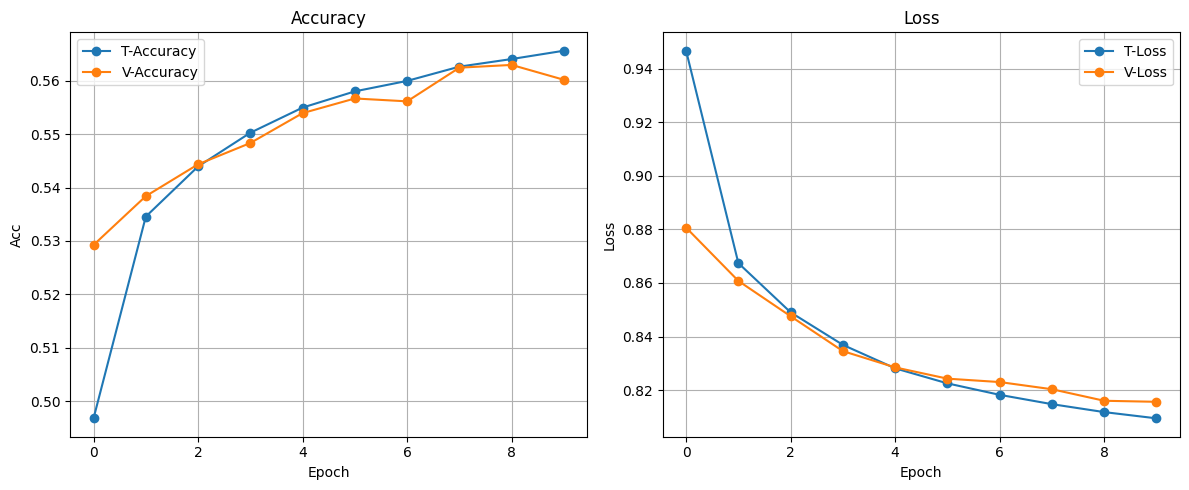

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='T-Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='V-Accuracy', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='T-Loss', marker='o')
plt.plot(history.history['val_loss'], label='V-Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
indices = np.random.choice(len(X_val_questions_padded), 5, replace=False)

test_questions = X_val_questions_padded[indices]
test_scenes = X_val_scenes_padded[indices]
test_labels = y_val_encoded[indices]

predict = model.predict({'question_input': test_questions, 'scene_input': test_scenes})
predicted = np.argmax(predict, axis=1)

for i, idx in enumerate(indices):
    question_text = val_questions['questions'][idx]['question'] # original question
    true_answer = label_encoder.inverse_transform([test_labels[i]])[0]
    pred_answer = label_encoder.inverse_transform([predicted[i]])[0]
    print(f"--------------------------------------------------------------------------\nQuestion: {question_text}\nTrue Answer: {true_answer}\nPredicted Answer: {pred_answer}\n--------------------------------------------------------------------------\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
--------------------------------------------------------------------------
Question: There is a rubber thing that is the same size as the green ball; what shape is it?
True Answer: sphere
Predicted Answer: sphere
--------------------------------------------------------------------------

--------------------------------------------------------------------------
Question: Do the tiny cylinder that is to the right of the purple cylinder and the big gray cube have the same material?
True Answer: no
Predicted Answer: no
--------------------------------------------------------------------------

--------------------------------------------------------------------------
Question: What is the size of the thing that is on the right side of the shiny object in front of the tiny metal object left of the brown metallic cube?
True Answer: large
Predicted Answer: small
--------------------------------------------------------------------------

-----------------